In [2]:
train_file_path = "./data/pathology/all/train_data.json"
val_file_path = "./data/pathology/all/val_data.json"
test_file_path = "./data/pathology/all/test_data.json"

from transformers import AutoTokenizer
import torch

biogpt_tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/biogpt", torch_dtype=torch.float16
)

In [3]:
from typing import List
import json

def read_file(str):
    with open(str) as f:
        file = json.load(f)
    return file

def encode_text(tokenizer, text: List[str]):
    text_tokens = tokenizer(text)
    lengths = [sum(att) for att in text_tokens.attention_mask]
    return lengths

train_data = read_file(train_file_path)
val_data = read_file(val_file_path)
test_data = read_file(test_file_path)

# Data looks like:
# {'image': 'xxxx.pth'.
#  'caption': 'xxxxx'
#  'caption_all': 'xxxxxxx'}
# I want to calculate the length of the tokens of both caption and caption_all, seperatly

def get_lengths_caption(data, tokenizer):
    lengths = []
    for i in range(0, len(data), 100):
        batch = data[i:i+100]
        text = [d['caption'] for d in batch]
        lengths += encode_text(tokenizer, text)
    return lengths

def get_lengths_caption_all(data, tokenizer):
    lengths = []
    for i in range(0, len(data), 100):
        batch = data[i:i+100]
        text = [d['caption_all'] for d in batch]
        lengths += encode_text(tokenizer, text)
    return lengths

caption_lengths = get_lengths_caption(train_data+val_data, biogpt_tokenizer)
caption_all_lengths = get_lengths_caption_all(train_data+val_data, biogpt_tokenizer)

In [4]:
# Create dataframe on both the caption and caption_all lengths, and plot the distribution and do .describe() on both
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

caption_df = pd.DataFrame(caption_lengths, columns=['caption'])
caption_all_df = pd.DataFrame(caption_all_lengths, columns=['caption_all'])

# fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# sns.histplot(caption_df, ax=ax[0])
# sns.histplot(caption_all_df, ax=ax[1])
# plt.show()

print(caption_df.describe())
print()
print(caption_all_df.describe())

            caption
count  17666.000000
mean      91.305219
std       49.462715
min        1.000000
25%       58.000000
50%       81.000000
75%      110.000000
max      425.000000

        caption_all
count  17666.000000
mean     136.491566
std      103.441755
min       12.000000
25%       78.000000
50%      106.000000
75%      153.000000
max      912.000000


==== Train Metrics ====
Total patients: 12100
Total cases: 15880
Mean number of tokens: 119.07770780856423
Median number of tokens: 107.0
Minimum number of tokens: 2
Maximum number of tokens: 507


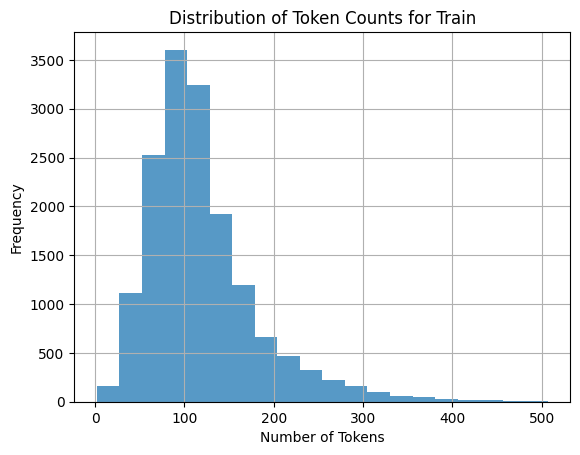

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


==== Validation Metrics ====
Total patients: 1512
Total cases: 2032
Mean number of tokens: 116.91535433070867
Median number of tokens: 105.0
Minimum number of tokens: 7
Maximum number of tokens: 514


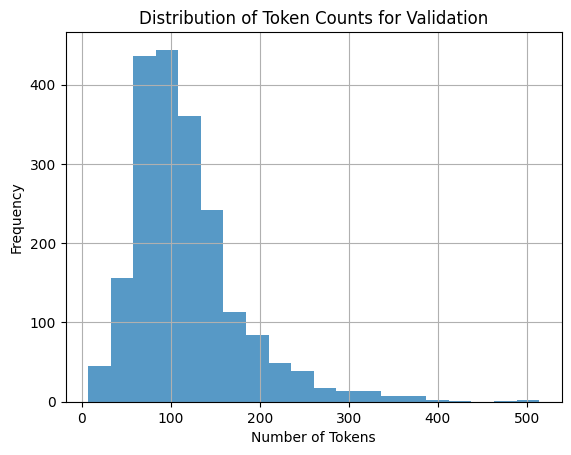

==== Test Metrics ====
Total patients: 1513
Total cases: 1995
Mean number of tokens: 117.48070175438596
Median number of tokens: 105.0
Minimum number of tokens: 5
Maximum number of tokens: 467


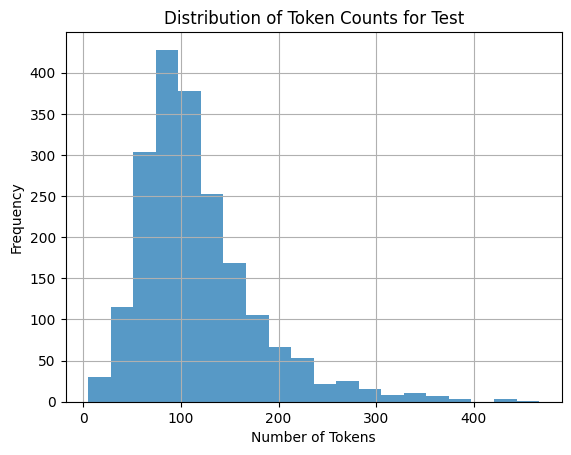

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer

def read_patient_ids(file_path):
    with open(file_path, 'r') as f:
        ids = f.read().strip().split(',')
        return set(ids)

# Paths
report_file = "./data/medical_reports/H&E_IHC_plus_preprocessed.json"
train_ids_file = "./data/train_val_test/patient_ids_train.txt"
val_ids_file = "./data/train_val_test/patient_ids_val.txt"
test_ids_file = "./data/train_val_test/patient_ids_test.txt"

# Reading patient IDs
train_patient_ids = read_patient_ids(train_ids_file)
val_patient_ids = read_patient_ids(val_ids_file)
test_patient_ids = read_patient_ids(test_ids_file)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load the report file once
with open(report_file, "r") as f:
    reports = json.load(f)

# Function to analyze a specific split
def analyze_split(patient_ids, split_name):
    token_counts = []
    num_cases = 0

    length = len(patient_ids)

    patient_id_and_cases = {}

    for patient_id in patient_ids:
        if patient_id in reports:
            patient_id_and_cases[patient_id] = {}
            for case_id, text in reports[patient_id].items():
                tokens = tokenizer.encode(text)
                token_counts.append(len(tokens))
                patient_id_and_cases[patient_id][case_id] = len(tokens)
                num_cases += 1

    # Calculating metrics
    mean_tokens = np.mean(token_counts)
    median_tokens = np.median(token_counts)
    min_tokens = np.min(token_counts)
    max_tokens = np.max(token_counts)

    # Printing metrics
    print(f"==== {split_name} Metrics ====")
    print(f"Total patients: {length}")
    print(f"Total cases: {num_cases}")
    print(f"Mean number of tokens: {mean_tokens}")
    print(f"Median number of tokens: {median_tokens}")
    print(f"Minimum number of tokens: {min_tokens}")
    print(f"Maximum number of tokens: {max_tokens}")

    # Plotting distribution
    plt.hist(token_counts, bins=20, alpha=0.75)
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Token Counts for {split_name}')
    plt.grid(True)
    plt.show()

    return patient_id_and_cases

# Analyze each split
train_patient_ids_and_cases = analyze_split(train_patient_ids, 'Train')
val_patient_ids_and_cases = analyze_split(val_patient_ids, 'Validation')
test_patient_ids_and_cases = analyze_split(test_patient_ids, 'Test')

In [6]:
import pandas as pd

with open(f'./data/patient_info/patient_characteristics.xlsx', 'rb') as f:
    patient_info = pd.read_excel(f)

In [ ]:
import re
 
def transform_case_id(string):
    """
    """
    # Regular expression to match the last number and any characters following it
    match = re.search(r'(\d+)([A-Z0-9&,\s]+)$', string)
   
    if match:
        number_part = match.group(1)  # Number part
        letter_part = match.group(2)  # Optional letter part
        rest_of_string = string[:match.start(1)]  # Part of the string before the match
        return rest_of_string + number_part, letter_part
   
    return string, ''  # Return the entire string and empty if no match
 
patient_info['specimen_corrected'] = patient_info['specimen'].apply(lambda x: "_".join(transform_case_id(x)))

In [9]:
# Transform the dictionary from
# patient_id: {case_id: token_count}
# to
# case_id: [patient_id, token_count, split_type]

def transform_patient_cases(patient_ids_and_cases, split_type):
    information = {}
    for patient_id, cases in patient_ids_and_cases.items():
        for case_id, token_count in cases.items():
            information[case_id] = [patient_id, token_count, split_type]
    return information

train_information = transform_patient_cases(train_patient_ids_and_cases, 'train')
val_information = transform_patient_cases(val_patient_ids_and_cases, 'val')
test_information = transform_patient_cases(test_patient_ids_and_cases, 'test')

# Combine the information
all_information = {**train_information, **val_information, **test_information}

# Create a dataframe
df = pd.DataFrame.from_dict(all_information, orient='index', columns=['patient_id', 'token_count', 'split_type'])

In [11]:
merged_df = df.merge(patient_info.set_index('specimen_corrected')[['label', 'diagnosis code']], left_index=True, right_index=True, how='left')
merged_df['label'] = merged_df['label'].fillna('Unknown')

In [13]:
with open(f'./data/patient_info/patient_characteristics.xlsx', 'rb') as f:
    mapping = pd.read_excel(f, sheet_name='Mapping')
mapping = mapping[['Diagnose code', 'Engels']].set_index('Diagnose code')['Engels'].to_dict()

In [14]:
merged_df['diagnosis name'] = merged_df['diagnosis code'].map(mapping)
merged_df = merged_df[merged_df['label']!='Unknown']


In [15]:
merged_df[merged_df['label']!='Unknown'].groupby('split_type')['patient_id'].count()

split_type
test      1970
train    15668
val       1998
Name: patient_id, dtype: int64

In [16]:
low_complexity_test = merged_df[(merged_df['split_type'] == 'test') & (merged_df['label'] == False)]
high_complexity_test = merged_df[(merged_df['split_type'] == 'test') & (merged_df['label'] == True)]

In [17]:
len(list(merged_df[merged_df['label']!='Unknown'].index))

19636

In [18]:
import json 

with open("./data/patient_info/all_cases.json", "w") as f:
    json.dump(list(merged_df[merged_df['label']!='Unknown'].index), f, indent=4)


In [19]:
import pandas as pd
import json 
with open('./data/patient_info/images_specimen_map.json', 'rb') as f:
    case_images_map = json.load(f)

new = {}
for medical_report_nr, images in case_images_map.items():
    new[medical_report_nr] = []
    for image in images:
        if image.endswith('1.dcm'):
            new_name = image[:-5]+'dcm'
            if new_name not in new[medical_report_nr]:
                new[medical_report_nr].append(new_name)
        elif image.endswith('2.dcm'):
            new_name = image[:-5]+'dcm'
            if new_name not in new[medical_report_nr]:
                new[medical_report_nr].append(new_name)
        elif image.endswith('3.dcm'):
            new_name = image[:-5]+'dcm'
            if new_name not in new[medical_report_nr]:
                new[medical_report_nr].append(new_name)
        elif image.endswith('4.dcm'):
            new_name = image[:-5]+'dcm'
            if new_name not in new[medical_report_nr]:
                new[medical_report_nr].append(new_name)
        else:
            new[medical_report_nr].append(image)

dct = {}
for key, values in new.items():
    dct[key] = len(values)
amount_of_wsi = pd.DataFrame(dct.values(), dct.keys(), columns=['n_WSIs'])

merged_df = merged_df[merged_df['label']!='Unknown']
n_wsis = merged_df.merge(amount_of_wsi, left_index=True, right_index=True, how='left')

In [20]:
n_wsis.groupby('split_type')['n_WSIs'].sum()

split_type
test      4286
train    33929
val       4218
Name: n_WSIs, dtype: int64

In [42]:
all_diagnosis = merged_df.groupby(['diagnosis code']).count()
all_diagnosis.index = all_diagnosis.index.astype(int)
all_diagnosis['amount'] = all_diagnosis['patient_id']
all_diagnosis = all_diagnosis[['amount']]
all_diagnosis

,amount
diagnosis code,
1,7186
2,7542
3,1335
4,873
5,78
...,...
61,1
62,1
63,2


In [21]:
n_wsis.groupby('split_type')['n_WSIs'].sum().sum()

42433

In [41]:
with open(f'./data/patient_info/categories_high_complexity.xlsx', 'rb') as f:
    mapping_high_complexity = pd.read_excel(f)
category_mapping = mapping_high_complexity[['Diagnosis', 'category index']].set_index(['Diagnosis'])['category index'].to_dict()

In [74]:
high_complexity_test['high_complexity_category'] = high_complexity_test['diagnosis name'].str.strip().map(category_mapping).astype(int)

/tmp/ipykernel_150870/1565493292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_complexity_test['high_complexity_category'] = high_complexity_test['diagnosis name'].str.strip().map(category_mapping).astype(int)


In [75]:
# Import the random module and set a fixed random seed
import random
random.seed(42)  # You can change 42 to any other fixed number to change the reproducibility baseline

reports_low_complexity = []

for i in ["Dermal nevus", "Compound nevus", "Junctional nevus"]:
    sample_n = 5
    subset = low_complexity_test[low_complexity_test['diagnosis name'] == i]

    # Use random_state in .sample() for reproducibility
    sample_list = list(subset.sample(sample_n, random_state=42).index)
    reports_low_complexity += sample_list

while len(reports_low_complexity) < 25:
    random_report = low_complexity_test.sample(1, random_state=random.randint(0, 10000)).index[0]

    if random_report not in reports_low_complexity:
        reports_low_complexity.append(random_report)

reports_high_complexity = []
for i in range(1, 9):
    sample_n = 3
    if i == 1:
        sample_n = 4
        
    subset = high_complexity_test[high_complexity_test['high_complexity_category'] == i]
    sample_list = list(subset.sample(sample_n, random_state=42).index)
    reports_high_complexity += sample_list

len(reports_low_complexity), len(reports_high_complexity)

(25, 25)

In [78]:
split_types = ['train', 'val', 'test']

# Create a dataframe from these results
info = {}
for split_type in split_types:
    split_df = merged_df[merged_df['split_type'] == split_type]
    info[split_type] = split_df['label'].value_counts(normalize=True)

info_df = pd.DataFrame(info)
info_df

,train,val,test
label,,,
False,0.809635,0.805118,0.800501
True,0.177015,0.178150,0.186967
Unknown,0.013350,0.016732,0.012531


In [86]:
merged_df = merged_df[merged_df['label']!='Unknown']

# Group the dataframe by 'split_type' and 'label'
grouped = merged_df.groupby(['split_type', 'label'])

# Get descriptive statistics for 'token_count' in each group
token_distribution = grouped['token_count'].describe()

# Display the results
token_distribution

count        mean        std   min     25%    50%     75%  \
split_type label                                                                
test       False   1597.0  105.552912  48.207771   7.0   73.00   97.0  128.00   
           True     373.0  167.109920  80.306879   5.0  111.00  156.0  202.00   
train      False  12857.0  108.832465  52.190924   5.0   76.00  100.0  130.00   
           True    2811.0  163.941658  79.091686   2.0  110.00  153.0  208.00   
val        False   1636.0  106.083741  48.750501   7.0   74.00   99.0  128.00   
           True     362.0  165.174033  83.367525  25.0  107.25  153.5  210.75   

                    max  
split_type label         
test       False  467.0  
           True   434.0  
train      False  501.0  
           True   507.0  
val        False  403.0  
           True   514.0

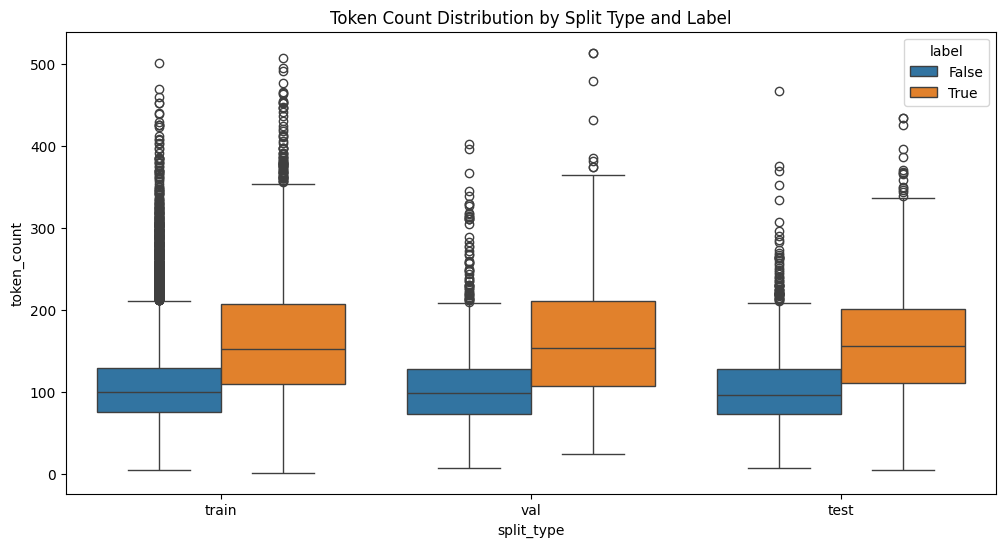

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index to turn group variables into columns
reset_df = merged_df.reset_index()

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='split_type', y='token_count', hue='label', data=reset_df)
plt.title('Token Count Distribution by Split Type and Label')
plt.show()

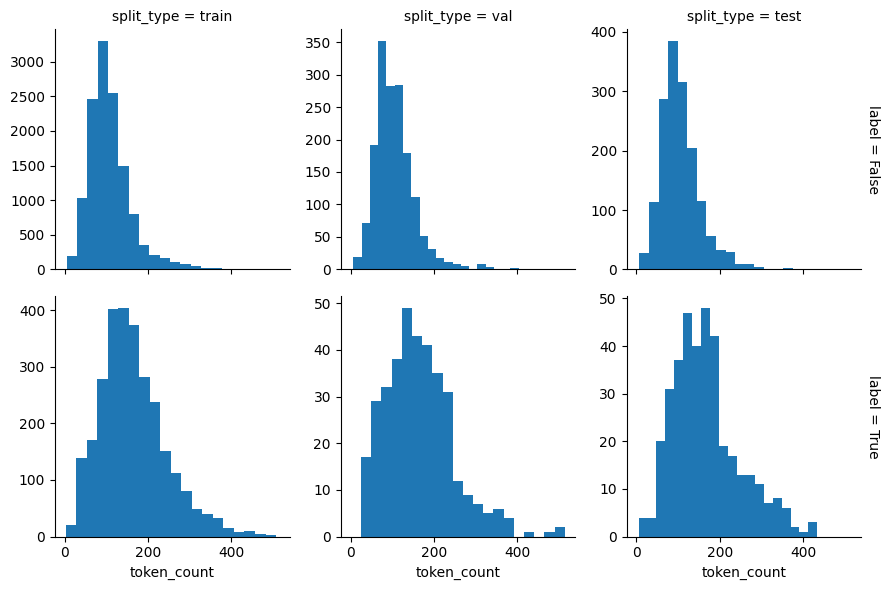

In [90]:
# Create histograms with independent y-axes
g = sns.FacetGrid(reset_df, col='split_type', row='label', margin_titles=True, sharey=False)
g.map(plt.hist, 'token_count', bins=20)
plt.show()